This notebook demonstrates the recording and processing of digitial audio signal

In [1]:
import math
import secrets
import time
import struct

from typing import Callable, Any

import numpy as np
import numpy.fft
import matplotlib.pyplot as plt
%matplotlib inline

import sounddevice as sd

import utils
import silk

In [2]:
fsps=8000

Let's first record some audio, click start to record. Interrupt to stop.

In [3]:
def record_until_interruption(fsps):
    recorder = sd.InputStream(samplerate=fsps, channels=1, dtype='int16')
    buffer = []
    recorder.start()
    try:
        while True:
            avail = recorder.read_available
            # data = np.zeros((avail,), dtype='int16')
            data, overflow = recorder.read(avail)
            if overflow:
                print(f"warning: data overflow")
            buffer.append(data)
            # print(f"saved {len(data)} samples")
            time.sleep(0.02)
    except KeyboardInterrupt:
        recorder.stop()
        res = np.concatenate(buffer)
        print(f"saved {len(res)} samples")
        return res
    
samples = record_until_interruption(fsps)

saved 35370 samples


In [4]:
print(samples.shape)
# print(samples)

(35370, 1)


Listen to it to ensure it indeed records the data

In [5]:
sd.play(samples, samplerate=fsps, blocking=True)

In [6]:
block_size = int(0.1 * fsps) # each packet is 0.1s

Initialize the SILK encoder

In [7]:
encoder = silk.Encoder()
ec = silk.EncoderControl(sample_rate=8000, max_internal_sample_rate=8000, bit_rate=5000, packet_size=block_size)

Pad the sample so that it's a multiple of `block_size`

In [8]:
need_to_pad = len(samples) % block_size
need_to_pad

170

In [9]:
need_to_pad = 0 if len(samples) % block_size == 0 else block_size - (len(samples) % block_size)
padded_samples = np.pad(samples, ((0, need_to_pad), (0, 0))).reshape(((len(samples) + need_to_pad) // block_size, block_size))

Encode the packets

In [10]:
res = []
for x in padded_samples:
    encoded_data = encoder.encode(x, ec)
    res.append(encoded_data)

Now, `res` contains the packets encoded. We can encrypt it using the format we provided (see `packet.py`).

(Optional) write the encoded output to a SILK file (that can be decoded by the `decoder` test program provided by the SILK library)

In [15]:
def write_silk_file(filename: str, packets: list):
    with open(filename, 'wb') as f:
        f.write(b'#!SILK_V3')
        for x in packets:
            f.write(struct.pack("<h", len(x)))
            f.write(x)

write_silk_file('test_output.bin', res)

In [24]:
print(len(res))

35


Let's try decoding it

In [11]:
decoded = []
decoder = silk.Decoder(sample_rate=fsps)
for x in res:
    # print(x)
    decoded_data = decoder.decode2(x)
    decoded.append(decoded_data)
    print(len(decoded_data))

output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800
output_size: 160
output_size: 160
output_size: 160
output_size: 160
output_size: 160
5
800

In [12]:
decoded_samples = np.concatenate([np.frombuffer(x, dtype='int16') for x in decoded])

In [13]:
print(len(decoded_samples))

36000


Play the decoded samples to see it actually works

In [14]:
sd.play(decoded_samples, samplerate=fsps, blocking=True)

Below are drafts

In [16]:
correct_decoded = utils.read_raw_audio('test_output.raw')

In [32]:
sd.play(correct_decoded, samplerate=fsps, blocking=True)

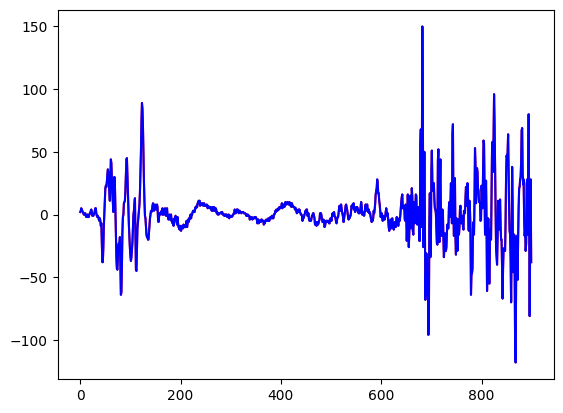

In [17]:
plt.figure()
plt.plot(decoded_samples[0:900], 'r')
plt.plot(correct_decoded[0:900], 'b')
plt.show()